# Getting Started

In this project, we will analyze a dataset that describes the customer order summary of a Food Delivery business. One of the objectives of this project is to decsribe the variations in the different types of customers that use the app and hence segment the customers into useful categories. Doing so would help the Food Delivery Service structure their services and business strategies(personalization) by making use of the relevant insights.

The dataset can be found in the same directory. The dataset includes features such as:
-  **customer_id** - Unique customer Id of a customer
-  **first_time** - The first time the customer logged into the app
-  **recent_time** - The most recent time when the customer logged into the app
-  **avg_dist_from_rest** - Average distance from the restaurant to the customer's delivery address
-  **avg_delivery_time** - Average time taken to make a successful order delivery to the customer
-  **n_orders**, **n_orders_in_last_week**, **n_orders_in_last_4_weeks** - Number of orders made by the customer in last 7 days, last 4 weeks, total respectively
-  **amount**, **amount_in_last_week**, **amount_in_last_4_weeks** - Amount spent by the customer in last 7 days, last 4 weeks, total respectively

In [220]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np
from numpy import log

# matplotlib, seaborn for visualization
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from IPython.display import display

import datetime as dt
from datetime import timedelta
from collections import Counter
import math

# sklearn for model selection and building
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import pca
%matplotlib inline

# Data Cleaning and Wrangling

In [146]:
# read data into dataframe
data = pd.read_excel('customer_order_summary.csv.xlsx')

# creating a copy of dataset
df = data.copy()

In [147]:
df.shape

(10000, 11)

In [148]:
df.columns

Index([u'customer_id', u'first_time', u'recent_time', u'n_orders',
       u'n_orders_in_last_week', u'n_orders_in_last_4_weeks', u'amount',
       u'amount_in_last_week', u'amount_in_last_4_weeks',
       u'avg_dist_from_rest', u'avg_delivery_time'],
      dtype='object')

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
customer_id                 10000 non-null int64
first_time                  10000 non-null datetime64[ns]
recent_time                 10000 non-null datetime64[ns]
n_orders                    10000 non-null int64
n_orders_in_last_week       1923 non-null float64
n_orders_in_last_4_weeks    4341 non-null float64
amount                      10000 non-null int64
amount_in_last_week         10000 non-null int64
amount_in_last_4_weeks      10000 non-null int64
avg_dist_from_rest          10000 non-null float64
avg_delivery_time           10000 non-null int64
dtypes: datetime64[ns](2), float64(3), int64(6)
memory usage: 859.4 KB


In [150]:
df.isnull().sum()

customer_id                    0
first_time                     0
recent_time                    0
n_orders                       0
n_orders_in_last_week       8077
n_orders_in_last_4_weeks    5659
amount                         0
amount_in_last_week            0
amount_in_last_4_weeks         0
avg_dist_from_rest             0
avg_delivery_time              0
dtype: int64

In [151]:
# function to find percentage of missing values per column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

print missing_values_table(df)

Your selected dataframe has 11 columns.
There are 2 columns that have missing values.
                          Missing Values  % of Total Values
n_orders_in_last_week               8077               80.8
n_orders_in_last_4_weeks            5659               56.6


In [152]:
df[df['n_orders_in_last_4_weeks'].isnull() == True]['amount_in_last_4_weeks'].mean()

0.0

In [153]:
df[df['n_orders_in_last_week'].isnull() == True]['amount_in_last_week'].mean()

0.0

Since, the average amount spent by customer in last 7 days and last 4 weeks is 0 for all the customer with missing values for column **n_orders_in_last_week** and **n_orders_in_last_4_weeks**, therefore we can replace the corresponding missing values by 0s.

In [154]:
# imputing missing values as zeros
df['n_orders_in_last_week'].fillna(0, inplace=True)
df['n_orders_in_last_4_weeks'].fillna(0, inplace=True)

In [155]:
df.isnull().any()

customer_id                 False
first_time                  False
recent_time                 False
n_orders                    False
n_orders_in_last_week       False
n_orders_in_last_4_weeks    False
amount                      False
amount_in_last_week         False
amount_in_last_4_weeks      False
avg_dist_from_rest          False
avg_delivery_time           False
dtype: bool

In [156]:
df.head()

,customer_id,first_time,recent_time,n_orders,n_orders_in_last_week,n_orders_in_last_4_weeks,amount,amount_in_last_week,amount_in_last_4_weeks,avg_dist_from_rest,avg_delivery_time
0,1269647,2015-06-29 10:57:00,2015-12-10 02:18:00,212,6.0,43.0,138808,4291,26853,1.6,51
1,167631,2015-07-04 15:39:00,2015-12-15 14:42:00,211,8.0,19.0,56404,1925,4177,2.2,42
2,301524,2015-06-26 09:56:00,2015-12-09 20:45:00,189,9.0,33.0,36020,1772,6404,2.5,57
3,1268254,2015-07-01 01:51:00,2015-12-14 01:43:00,184,6.0,37.0,32489,975,7110,3.1,55
4,357161,2015-07-11 18:34:00,2015-12-19 23:26:00,182,4.0,23.0,85150,1738,9958,2.4,36


Now, the values in most of the columns should be positive since number of orders, amount, distance and time cannot be negative. Therefore we do a scan to check if there are any columns with negative values.

In [157]:
# Checking for negative and inf values

def get_column_with_invalid_values(df):
    for column_name in df.columns:
        if column_name not in ['first_time', 'recent_time']:
            if (df[column_name].min()) < 0 or (np.isinf(df[column_name].max() == True)):
                return column_name
            
print get_column_with_invalid_values(df)

avg_dist_from_rest


In [158]:
max_avg_dist = df['avg_dist_from_rest'].max()
min_avg_dist = df['avg_dist_from_rest'].min()
print max_avg_dist
print min_avg_dist

5.9
-0.8


So, there are negative values in the column **avg_dist_from_rest** which cannot be valid as no restaurant can be at a negative distance from any customer's delivery address. We find that there are 66 such invalid values.

In [159]:
# count how many values are negative
len(df[df['avg_dist_from_rest'] <= 0])

66

In [160]:
# mean delivery time for the customers with invalid avg_dist_from_res
df[df['avg_dist_from_rest'] <= 0]['avg_delivery_time'].mean()

33.42424242424242

In [161]:
# mean delivery time for restaurants within 1 km of the customer's delivery address
df[(df['avg_dist_from_rest'] > 0) & (df['avg_dist_from_rest'] < 1)]['avg_delivery_time'].mean()

35.181695827725434

Either these 66 values are completely incorrect or there has been an error while recording the values and the 
negative sign is accidental. Since, we find that the mean **avg_delivery_time**(33.42) of the records with negative 
**avg_dist_from_rest** values is comparable with the mean **avg_delivery_time**(35.18) of the records that have 
**avg_dist_from_rest** < 1. 
Therefore, we can assume the latter and convert negative values to postive values. We shall also drop the records with **avg_distance_from_rest** == 0 as that would be invalid.

In [162]:
# replacing negative values for Avg_DistanceFromResturant with positive values
df['avg_dist_from_rest'] = df['avg_dist_from_rest'].apply(lambda x: abs(x))

In [163]:
# Dropping records with Avg_DistanceFromResturant = 0
clean_df = df[df['avg_dist_from_rest'] > 0.0]

# Feature Engineering

Let's create some new features that could aid our analysis and objective such as:

-  **recency** = no. of days since last order
-  **avg_amount_per_order** = total amount / total no. of orders

In [164]:
clean_df['recent_time'].max()

Timestamp('2016-01-13 05:54:00')

In [165]:
clean_df['first_time'].min()

Timestamp('2015-06-05 17:21:00')

In [166]:
clean_df.tail()

,customer_id,first_time,recent_time,n_orders,n_orders_in_last_week,n_orders_in_last_4_weeks,amount,amount_in_last_week,amount_in_last_4_weeks,avg_dist_from_rest,avg_delivery_time
9995,995495,2015-12-05 05:41:00,2015-12-05 10:58:00,1,0.0,1.0,69,0,69,1.3,23
9996,337003,2015-07-17 12:30:00,2015-07-20 17:43:00,1,0.0,0.0,305,0,0,2.9,49
9997,993928,2015-11-11 20:27:00,2015-11-14 21:05:00,1,0.0,0.0,85,0,0,2.2,53
9998,398583,2015-07-06 04:25:00,2015-07-10 20:19:00,1,0.0,0.0,630,0,0,0.1,20
9999,462448,2015-07-25 00:36:00,2015-07-25 06:21:00,1,0.0,0.0,293,0,0,3.7,49


Upon checking the tail values of the dataset we find that the for customer with id=**995495** **first_time = 2015-12-05 05:41:00** and **recent_time = 2015-12-05 10:58:00** and the **n_orders = 1**. Thus, since **first_time** is not equal to **recent_time** while the total number of orders is 1, we can assume that the **first_time** is the first time a customer signed into the app and the **recent_time** is the most recent time when the same user browsed the app.
As the most **recent_time** among all customers is **2016-01-13**, let's assume this data was collected on 2016-01-14 for calculating recency of customers on the app. Also, the dataset spans across 8 months.

In [168]:
# date when the data was collected (assumption)
NOW = dt.datetime(2016, 1, 14)

# converting 'First Time' and "Recent Time' to datetime
clean_df['first_time'] = pd.to_datetime(clean_df['first_time'])
clean_df['recent_time'] = pd.to_datetime(clean_df['recent_time'])

# Create recency and avg_amount_per_order as new features
clean_df['recency'] = NOW - clean_df['recent_time']
clean_df['recency'] = [x.days for x in clean_df['recency']]
clean_df['avg_amount_per_order'] = clean_df['amount'] / clean_df['n_orders']

/Users/shwetabhatt/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/shwetabhatt/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/shwetabhatt/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

In [169]:
clean_df.head()

,customer_id,first_time,recent_time,n_orders,n_orders_in_last_week,n_orders_in_last_4_weeks,amount,amount_in_last_week,amount_in_last_4_weeks,avg_dist_from_rest,avg_delivery_time,recency,avg_amount_per_order
0,1269647,2015-06-29 10:57:00,2015-12-10 02:18:00,212,6.0,43.0,138808,4291,26853,1.6,51,34,654.754717
1,167631,2015-07-04 15:39:00,2015-12-15 14:42:00,211,8.0,19.0,56404,1925,4177,2.2,42,29,267.317536
2,301524,2015-06-26 09:56:00,2015-12-09 20:45:00,189,9.0,33.0,36020,1772,6404,2.5,57,35,190.582011
3,1268254,2015-07-01 01:51:00,2015-12-14 01:43:00,184,6.0,37.0,32489,975,7110,3.1,55,30,176.570652
4,357161,2015-07-11 18:34:00,2015-12-19 23:26:00,182,4.0,23.0,85150,1738,9958,2.4,36,25,467.857143


# Data Exploration

In [170]:
clean_df.shape

(9978, 13)

In [171]:
clean_df.columns

Index([             u'customer_id',               u'first_time',
                    u'recent_time',                 u'n_orders',
          u'n_orders_in_last_week', u'n_orders_in_last_4_weeks',
                         u'amount',      u'amount_in_last_week',
         u'amount_in_last_4_weeks',       u'avg_dist_from_rest',
              u'avg_delivery_time',                  u'recency',
           u'avg_amount_per_order'],
      dtype='object')

In [172]:
clean_df.describe()

,customer_id,n_orders,n_orders_in_last_week,n_orders_in_last_4_weeks,amount,amount_in_last_week,amount_in_last_4_weeks,avg_dist_from_rest,avg_delivery_time,recency,avg_amount_per_order
count,9.978000e+03,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000
mean,6.712876e+05,7.017939,0.334035,1.390259,2257.037482,109.665865,456.169673,2.363420,36.912508,79.339647,360.213556
std,3.902611e+05,13.130442,0.910865,3.044430,5141.272390,397.448829,1238.865794,0.964743,13.176676,48.501740,373.361945
min,2.800000e+01,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.100000,15.000000,0.000000,0.083333
25%,3.360400e+05,1.000000,0.000000,0.000000,280.000000,0.000000,0.000000,1.700000,26.000000,40.000000,139.000000
50%,6.678395e+05,2.000000,0.000000,0.000000,689.000000,0.000000,0.000000,2.400000,36.500000,66.000000,281.125000
75%,1.004866e+06,7.000000,0.000000,1.000000,2043.500000,0.000000,399.000000,3.100000,47.000000,112.000000,478.390909
max,1.355445e+06,212.000000,14.000000,46.000000,138808.000000,10150.000000,26853.000000,5.900000,83.000000,219.000000,9906.500000


We can drop **first_time**, **recent_time**, **n_orders_in_last_week**, **n_orders_in_last_4_weeks**, **amount_in_last_week** and **amount_in_last_4_weeks** to remove redundancy.

In [174]:

clean_df.drop(['first_time', 'recent_time', 'n_orders_in_last_week', 'n_orders_in_last_4_weeks', \
                         'amount_in_last_week', 'amount_in_last_4_weeks'], axis = 1, inplace = True)

/Users/shwetabhatt/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
features = pd.DataFrame()
features = clean_df
features.head()
features.drop(['customer_id'], axis=1, inplace=True)

In [183]:
features.head()

,n_orders,amount,avg_dist_from_rest,avg_delivery_time,recency,avg_amount_per_order
0,212,138808,1.6,51,34,654.754717
1,211,56404,2.2,42,29,267.317536
2,189,36020,2.5,57,35,190.582011
3,184,32489,3.1,55,30,176.570652
4,182,85150,2.4,36,25,467.857143


# Selecting Samples

Let's select a few sample data points and explore them in detail.

In [192]:
indices = [56, 430, 821]
samples = pd.DataFrame(features.loc[indices], columns = features.keys()).reset_index(drop = True)

print "Samples:"
samples

Samples:


,n_orders,amount,avg_dist_from_rest,avg_delivery_time,recency,avg_amount_per_order
0,81,52426,2.8,33,53,647.234568
1,31,8227,2.7,56,12,265.387097
2,20,1863,4.0,47,46,93.150000


From the above choosen samples, let's try to figure out what categories can we put each of the three customers into:
-  **Sample 0**: This customer is a big spender and frequent user of the app as the n_orders and amount for this customer is quite high compared to the mean/median. But has somehow lost touch(recence > 50)

-  **Sample 1** This customer is probably an above average spender but accessed the app more recently as compared to the others. The customer has least avg_dist_from_rest also so resides in a region where restaurants are available.

-  **Sample 2** This is customer is a low spender, does not use the app much and has not used the app since past 45 days 

**Comparing Samples and Means**

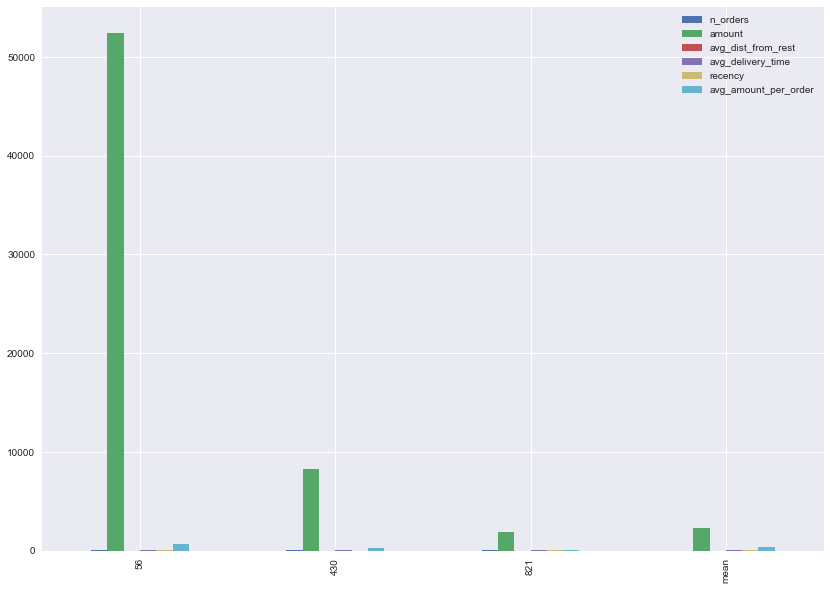

In [195]:
# get the means 
mean_df = features.describe().loc['mean', :]

# append the mean data to the samples
samples_bar = samples.append(mean_df)

# construct indices
samples_bar.index = indices + ['mean']

# plot the bar plot
samples_bar.plot(kind='bar', figsize=(14,10))


# Feature Relevance

Let's see if the selected features are all independent or some of them are correlated and can be removed

# Visualize Feature Distributions

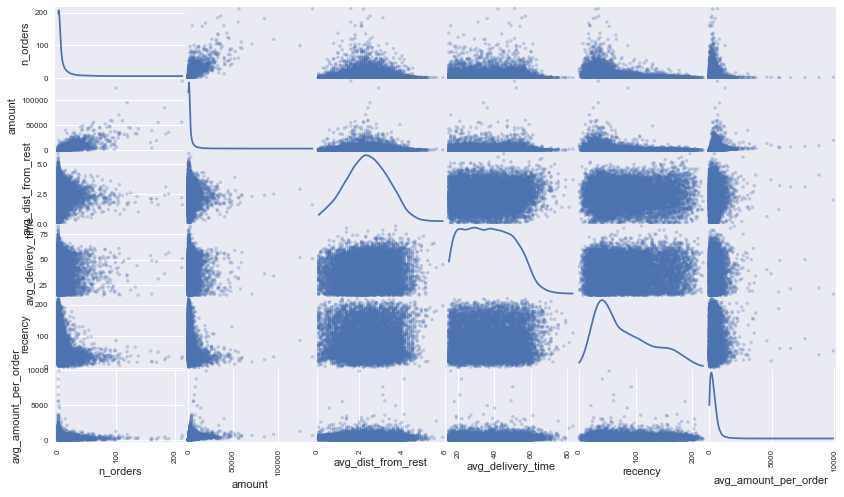

In [188]:
pd.plotting.scatter_matrix(features, alpha=0.3, figsize=(14,8), diagonal='kde');

Looking at the plot above, we can see that there is one pair that exhibits some level of correlation

-  n_orders and amount


In [190]:
correlations_data = features.corr()['amount'].sort_values()
correlations_data

recency                -0.244461
avg_dist_from_rest     -0.016758
avg_delivery_time       0.002667
avg_amount_per_order    0.227655
n_orders                0.763239
amount                  1.000000
Name: amount, dtype: float64

Again, we see that there is a high correlation value of 0.763239 between n_orders and amount. Let's check if it is possible to determine the value of amount using the rest of the features. We can easily determine this by training a supervised regression learner on the subset of features with the feature 'amount' removed, then score how well that model can predict **amount**.

In [197]:
# Make a copy of data for regression, by droping the amount column
reg_data = features.drop(['amount'], axis=1)

# Split data into training and test sets by using the given feature as target
X_train, X_test, y_train, y_test = train_test_split(reg_data, features['amount'], test_size=0.25, random_state=101)

# Create a decision tree regressor and fit it into the training set
regressor = DecisionTreeRegressor(random_state=101).fit(X_train,y_train)

# Find the prediction score using the testing set
score = regressor.score(X_test,y_test)

score

0.9674964992367574


The coefficient of determination, R^2 ranges between 0 and 1, with 1 being a perfect fit. While a negative R2 implies that the model fails to fit the data.
R2 score for amount as dependent variable : 0.9674964992367574 
Therefore, we can safely remove **amount** from the features as it can be predicted from other variables and hence is not an important feature independently.

In [200]:
model_data = reg_data

**Correlation Matrix**

For the purpose of cross referencing with the scatter matrix plotted above and to draw more accurate insights from the data, let's plot a correlation matrix. The higher the color on the bar, stronger the relation.

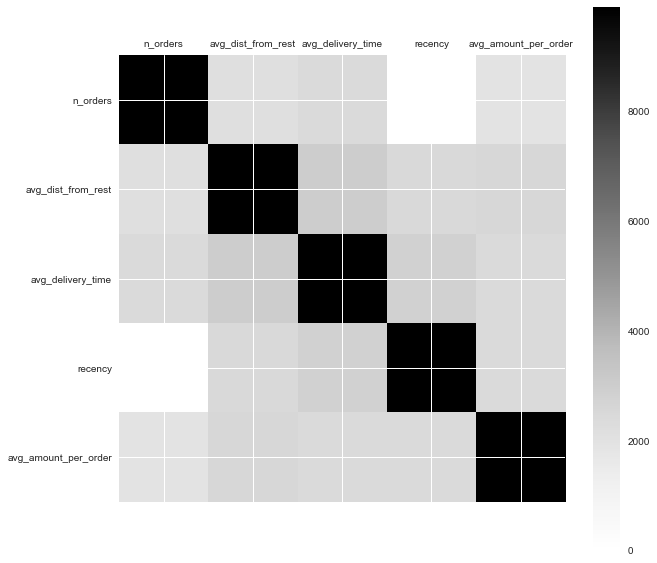

In [201]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(df, interpolation='nearest')
    ax.matshow(corr)
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);


plot_corr(model_data)

The results show that the features that we have finally selected are not much correlated with each other.

# Data Preprocessing

In [203]:
model_data.describe()

,n_orders,avg_dist_from_rest,avg_delivery_time,recency,avg_amount_per_order
count,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000
mean,7.017939,2.363420,36.912508,79.339647,360.213556
std,13.130442,0.964743,13.176676,48.501740,373.361945
min,1.000000,0.100000,15.000000,0.000000,0.083333
25%,1.000000,1.700000,26.000000,40.000000,139.000000
50%,2.000000,2.400000,36.500000,66.000000,281.125000
75%,7.000000,3.100000,47.000000,112.000000,478.390909
max,212.000000,5.900000,83.000000,219.000000,9906.500000


From the mean and median values observed above, we can see that the data is quite skewed. Hence, we need to perform some feature scaling and remove outliers to get a better representation of the data and to ensure that the results obtained from the analysis are significant and meaningful.

# Feature Scaling

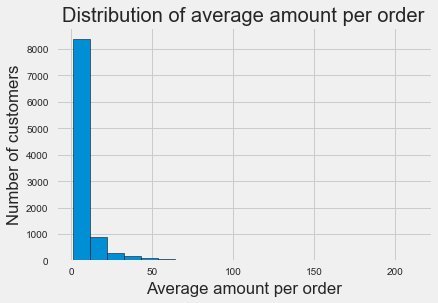

In [212]:
plt.style.use('fivethirtyeight')
plt.hist(model_data['n_orders'].dropna(), bins = 20, edgecolor = 'k')
plt.xlabel('Average amount per order'); plt.ylabel('Number of customers')
plt.title('Distribution of average amount per order')

Since, for **avg_amount_per_order**, **n_orders** and **recency** are highly skewed distributions i.e. their mean and median of the features vary significantly, it is useful to apply some non-linear scaling. Natural logarithm is one method that can transform the dataset and bring it closer to normal distribution. 

In [ ]:
# Splitting data into two subsets, one subset will undergo log transform and the other will undergo standard scaling

skewed_features = model_data[['avg_amount_per_order', 'n_orders', 'recency']]
normal_features = model_data[['avg_dist_from_rest', 'avg_delivery_time']]

**Scaling skewed features using natural logarithm**

In [327]:
log_features = skewed_features.apply(lambda x: np.log(x+1))

**Scaling normal features using Standard Scaler**

In [322]:
from sklearn import preprocessing
normalized_features = pd.DataFrame(preprocessing.normalize(normal_features), columns=['avg_dist_from_rest', \
                                                                                      'avg_delivery_time'])
normalized_features.describe()

,avg_dist_from_rest,avg_delivery_time
count,9978.000000,9978.000000
mean,0.072845,0.996430
std,0.042435,0.004433
min,0.001852,0.952424
25%,0.043957,0.995716
50%,0.063508,0.997981
75%,0.092459,0.999033
max,0.304776,0.999998


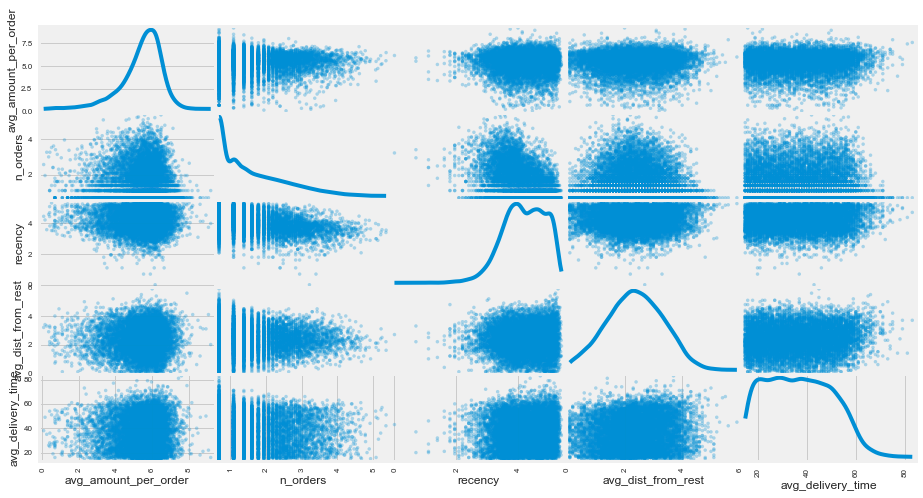

In [326]:
scaled_data = pd.concat([log_features, normal_features], axis=1)
pd.plotting.scatter_matrix(scaled_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

** Scaling all the features using natural logarithm**

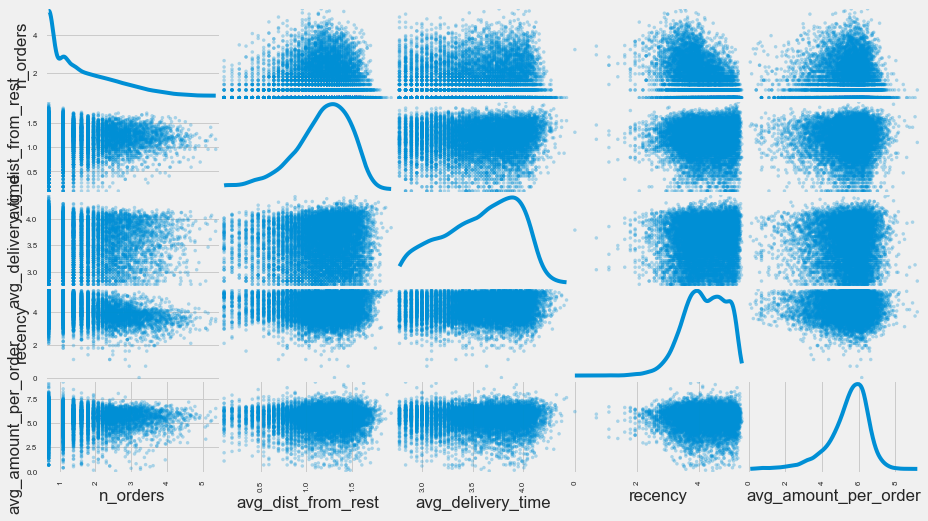

In [211]:
# scale the data using natural logarithm
log_data = model_data.apply(lambda x: np.log(x+1))

# scale the samples using natural logarithm
log_samples = samples.apply(lambda x: np.log(x+1))

# plot scatter matrix for each pair of newly-transformed data
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

After comparing both feature scaling techniques, we can observe that applying a natural logarithm scaling to the entire data transforms the distribution of each feature to become much more normal.

In [328]:
log_samples

,n_orders,amount,avg_dist_from_rest,avg_delivery_time,recency,avg_amount_per_order
0,4.406719,10.867177,1.335001,3.526361,3.988984,6.474253
1,3.465736,9.015298,1.308333,4.043051,2.564949,5.584951
2,3.044522,7.530480,1.609438,3.871201,3.850148,4.544889


# Outlier Detection

Presence of outliers makes the dataset skewed which would in turn affect the results of the analysis. Here, we can use the **Turkey's Method of identifying outliers**, according to which an outlier is calculated as 1.5 times the interquartile range(IQR). A data point which is an outlier step outside of the IQR for that feature is considered an outlier.

In [223]:
# select indices for outliers 
outliers = []

# find outliers for each feature

for feature in log_data.keys():
    
    # find Q1 (25th percentile) for the given feature
    Q1 = np.percentile(log_data[feature],25)
    
    # find Q3 (75th percentile) for the given feature
    Q3 = np.percentile(log_data[feature],75)
    
    # calculate outlier step using IQR
    outlier_step = (Q3-Q1) * 1.5
    
    # print the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    out = log_data[~((log_data[feature] >= Q1 - outlier_step) & (log_data[feature] <= Q3 + outlier_step))]
    display(out)
    
    outliers = outliers + list(out.index.values)
    
# creating list of outliers which are same across different features

outliers = list(set([x for x in outliers if outliers.count(x) > 1]))
 


Data points considered outliers for the feature 'n_orders':


,n_orders,avg_dist_from_rest,avg_delivery_time,recency,avg_amount_per_order
0,5.361292,0.955511,3.951244,3.555348,6.485787
1,5.356586,1.163151,3.761200,3.401197,5.592171
2,5.247024,1.252763,4.060443,3.583519,5.255316
3,5.220356,1.410987,4.025352,3.433987,5.179369
4,5.209486,1.223775,3.610918,3.258097,6.150298
5,5.147494,0.955511,3.465736,3.912023,5.787292
6,5.129899,1.131402,3.891820,2.890372,4.739899
7,5.081404,1.029619,2.833213,2.995732,5.515141
8,5.081404,1.131402,3.912023,2.995732,3.337325
9,5.068904,1.131402,4.007333,3.988984,4.581927


Data points considered outliers for the feature 'avg_dist_from_rest':


,n_orders,avg_dist_from_rest,avg_delivery_time,recency,avg_amount_per_order
432,3.465736,0.262364,3.891820,3.970292,6.394669
479,3.401197,0.336472,3.931826,4.077537,6.285034
1116,2.833213,0.336472,3.610918,1.609438,6.002497
1126,2.833213,0.336472,3.610918,3.218876,6.381181
1392,2.639057,0.095310,3.465736,2.079442,4.479956
1662,2.484907,0.262364,3.526361,3.332205,6.343081
1821,2.397895,0.182322,3.401197,3.367296,6.465522
2104,2.302585,0.095310,3.891820,3.135494,4.338017
2193,2.197225,0.182322,3.332205,3.367296,5.734150
2333,2.197225,0.262364,3.970292,3.218876,6.037274


Data points considered outliers for the feature 'avg_delivery_time':


,n_orders,avg_dist_from_rest,avg_delivery_time,recency,avg_amount_per_order


Data points considered outliers for the feature 'recency':


,n_orders,avg_dist_from_rest,avg_delivery_time,recency,avg_amount_per_order
21,4.663439,1.252763,3.583519,2.079442,5.792200
270,3.737670,0.875469,2.772589,2.079442,5.678089
308,3.663562,1.435085,3.688879,1.945910,5.471496
321,3.637586,0.916291,3.583519,1.945910,6.046925
329,3.637586,0.788457,3.433987,1.945910,6.337830
406,3.496508,1.029619,3.988984,1.945910,4.963937
442,3.433987,1.098612,4.007333,1.609438,6.590209
481,3.401197,1.335001,3.218876,1.945910,3.772365
488,3.401197,1.163151,3.044522,0.693147,5.534752
654,3.218876,1.280934,3.891820,1.791759,6.504226


Data points considered outliers for the feature 'avg_amount_per_order':


,n_orders,avg_dist_from_rest,avg_delivery_time,recency,avg_amount_per_order
32,4.574711,1.252763,3.970292,3.295837,2.967740
64,4.369448,1.435085,3.637586,3.135494,2.991879
118,4.094345,1.386294,4.043051,3.332205,3.031525
162,3.970292,0.832909,3.784190,3.931826,2.838854
167,3.951244,1.386294,2.890372,3.044522,2.860519
172,3.951244,0.916291,3.465736,3.178054,1.215669
257,3.761200,1.131402,3.663562,3.988984,2.967969
266,3.737670,0.993252,3.135494,3.931826,2.943154
281,3.713572,1.458615,4.043051,3.496508,2.649715
283,3.713572,0.875469,3.850148,3.332205,2.633686


In [224]:
print "Outliers: {}".format(outliers)
final_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)
print "The final dataset now has {} observations after removing outliers.".format(len(final_data))

Outliers: [32, 64, 9475, 9253, 1392, 9074, 6932, 21, 8308, 8283, 1116, 4574, 8469]
The final dataset now has 9965 observations after removing outliers.


In [264]:
final_data.describe()

,n_orders,avg_dist_from_rest,avg_delivery_time,recency,avg_amount_per_order
count,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000
mean,1.523664,1.166684,3.569984,4.183913,5.448629
std,0.917883,0.318737,0.371935,0.673454,1.085308
min,0.693147,0.095310,2.772589,0.000000,0.080043
25%,0.693147,0.993252,3.295837,3.713572,4.941642
50%,1.098612,1.223775,3.637586,4.204693,5.642793
75%,2.079442,1.410987,3.871201,4.727388,6.172744
max,5.361292,1.931521,4.430817,5.393628,9.201047


# Feature Transformation

After feature scaling and outlier removal, we can now apply PCA to the transformed dataset to find which dimensions of the data best maximize the variance of the features. In addition to finding these dimensions, PCA will also report the explained variance ratio of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In [256]:
from sklearn.decomposition import PCA

# Apply PCA by fitting the final transformed data with the same number of dimensions as the features
pca = PCA().fit(final_data)

## transform log_samples using pca fit
#pca_samples = pca.transform(log_samples)
print(pca.explained_variance_ratio_) 

[0.43609788 0.36467496 0.11109322 0.05149589 0.03663806]


The first and second feature explain approx. 80% of the variance in the data.
The first 3 features, in total, explain approx 91% of the variance.

In [257]:
print(pca.components_)

[[ 0.1538491  -0.00623129 -0.00296106 -0.06319785 -0.9860471 ]
 [ 0.86944172  0.0104262  -0.008722   -0.46531314  0.16543882]
 [-0.46893968 -0.00921691 -0.05653888 -0.88121681 -0.01645975]
 [ 0.02081704 -0.22307439 -0.97309459  0.05361177  0.00414378]
 [ 0.00798693 -0.97468217  0.22317132 -0.00851042  0.00728092]]


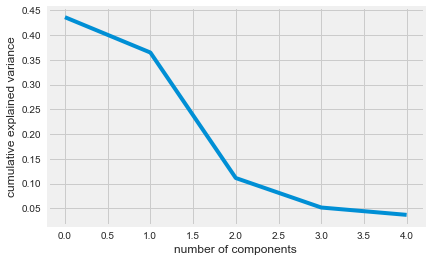

In [258]:
#Explained variance
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [254]:
'''def pca_results(final_data, pca):
    
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) 
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights") 
    ax.set_xticklabels(dimensions, rotation=0)

    # Display the explained variance ratios# 
    for i, ev in enumerate(pca.explained_variance_ratio_): 
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

pca_results = pca_results(data, pca)'''

'def pca_results(final_data, pca):\n    \n    # Dimension indexing\n    dimensions = [\'Dimension {}\'.format(i) for i in range(1,len(pca.components_)+1)]\n    \n    # PCA components\n    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) \n    components.index = dimensions\n\n    # PCA explained variance\n    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) \n    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = [\'Explained Variance\']) \n    variance_ratios.index = dimensions\n\n    # Create a bar plot visualization\n    fig, ax = plt.subplots(figsize = (14,8))\n\n    # Plot the feature weights as a function of the components\n    components.plot(ax = ax, kind = \'bar\')\n    ax.set_ylabel("Feature Weights") \n    ax.set_xticklabels(dimensions, rotation=0)\n\n    # Display the explained variance ratios# \n    for i, ev in enumerate(pca.explained_variance_ratio_): \n        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explai

# Dimensionality Reduction

In [284]:
# apply pca by fitting the final data with only two dimensions
pca = PCA(n_components=2).fit(final_data)

# transform the final data using the PCA fit
reduced_data = pca.transform(final_data)

# transform the log samples 
#pca_samples = pca.transform(log_samples)

# create DataFrame for reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])
reduced_data.head()

,Dimension 1,Dimension 2
0,-0.392360,3.795132
1,0.497074,3.718753
2,0.799406,3.481254
3,0.878759,3.517038
4,-0.066786,3.751723


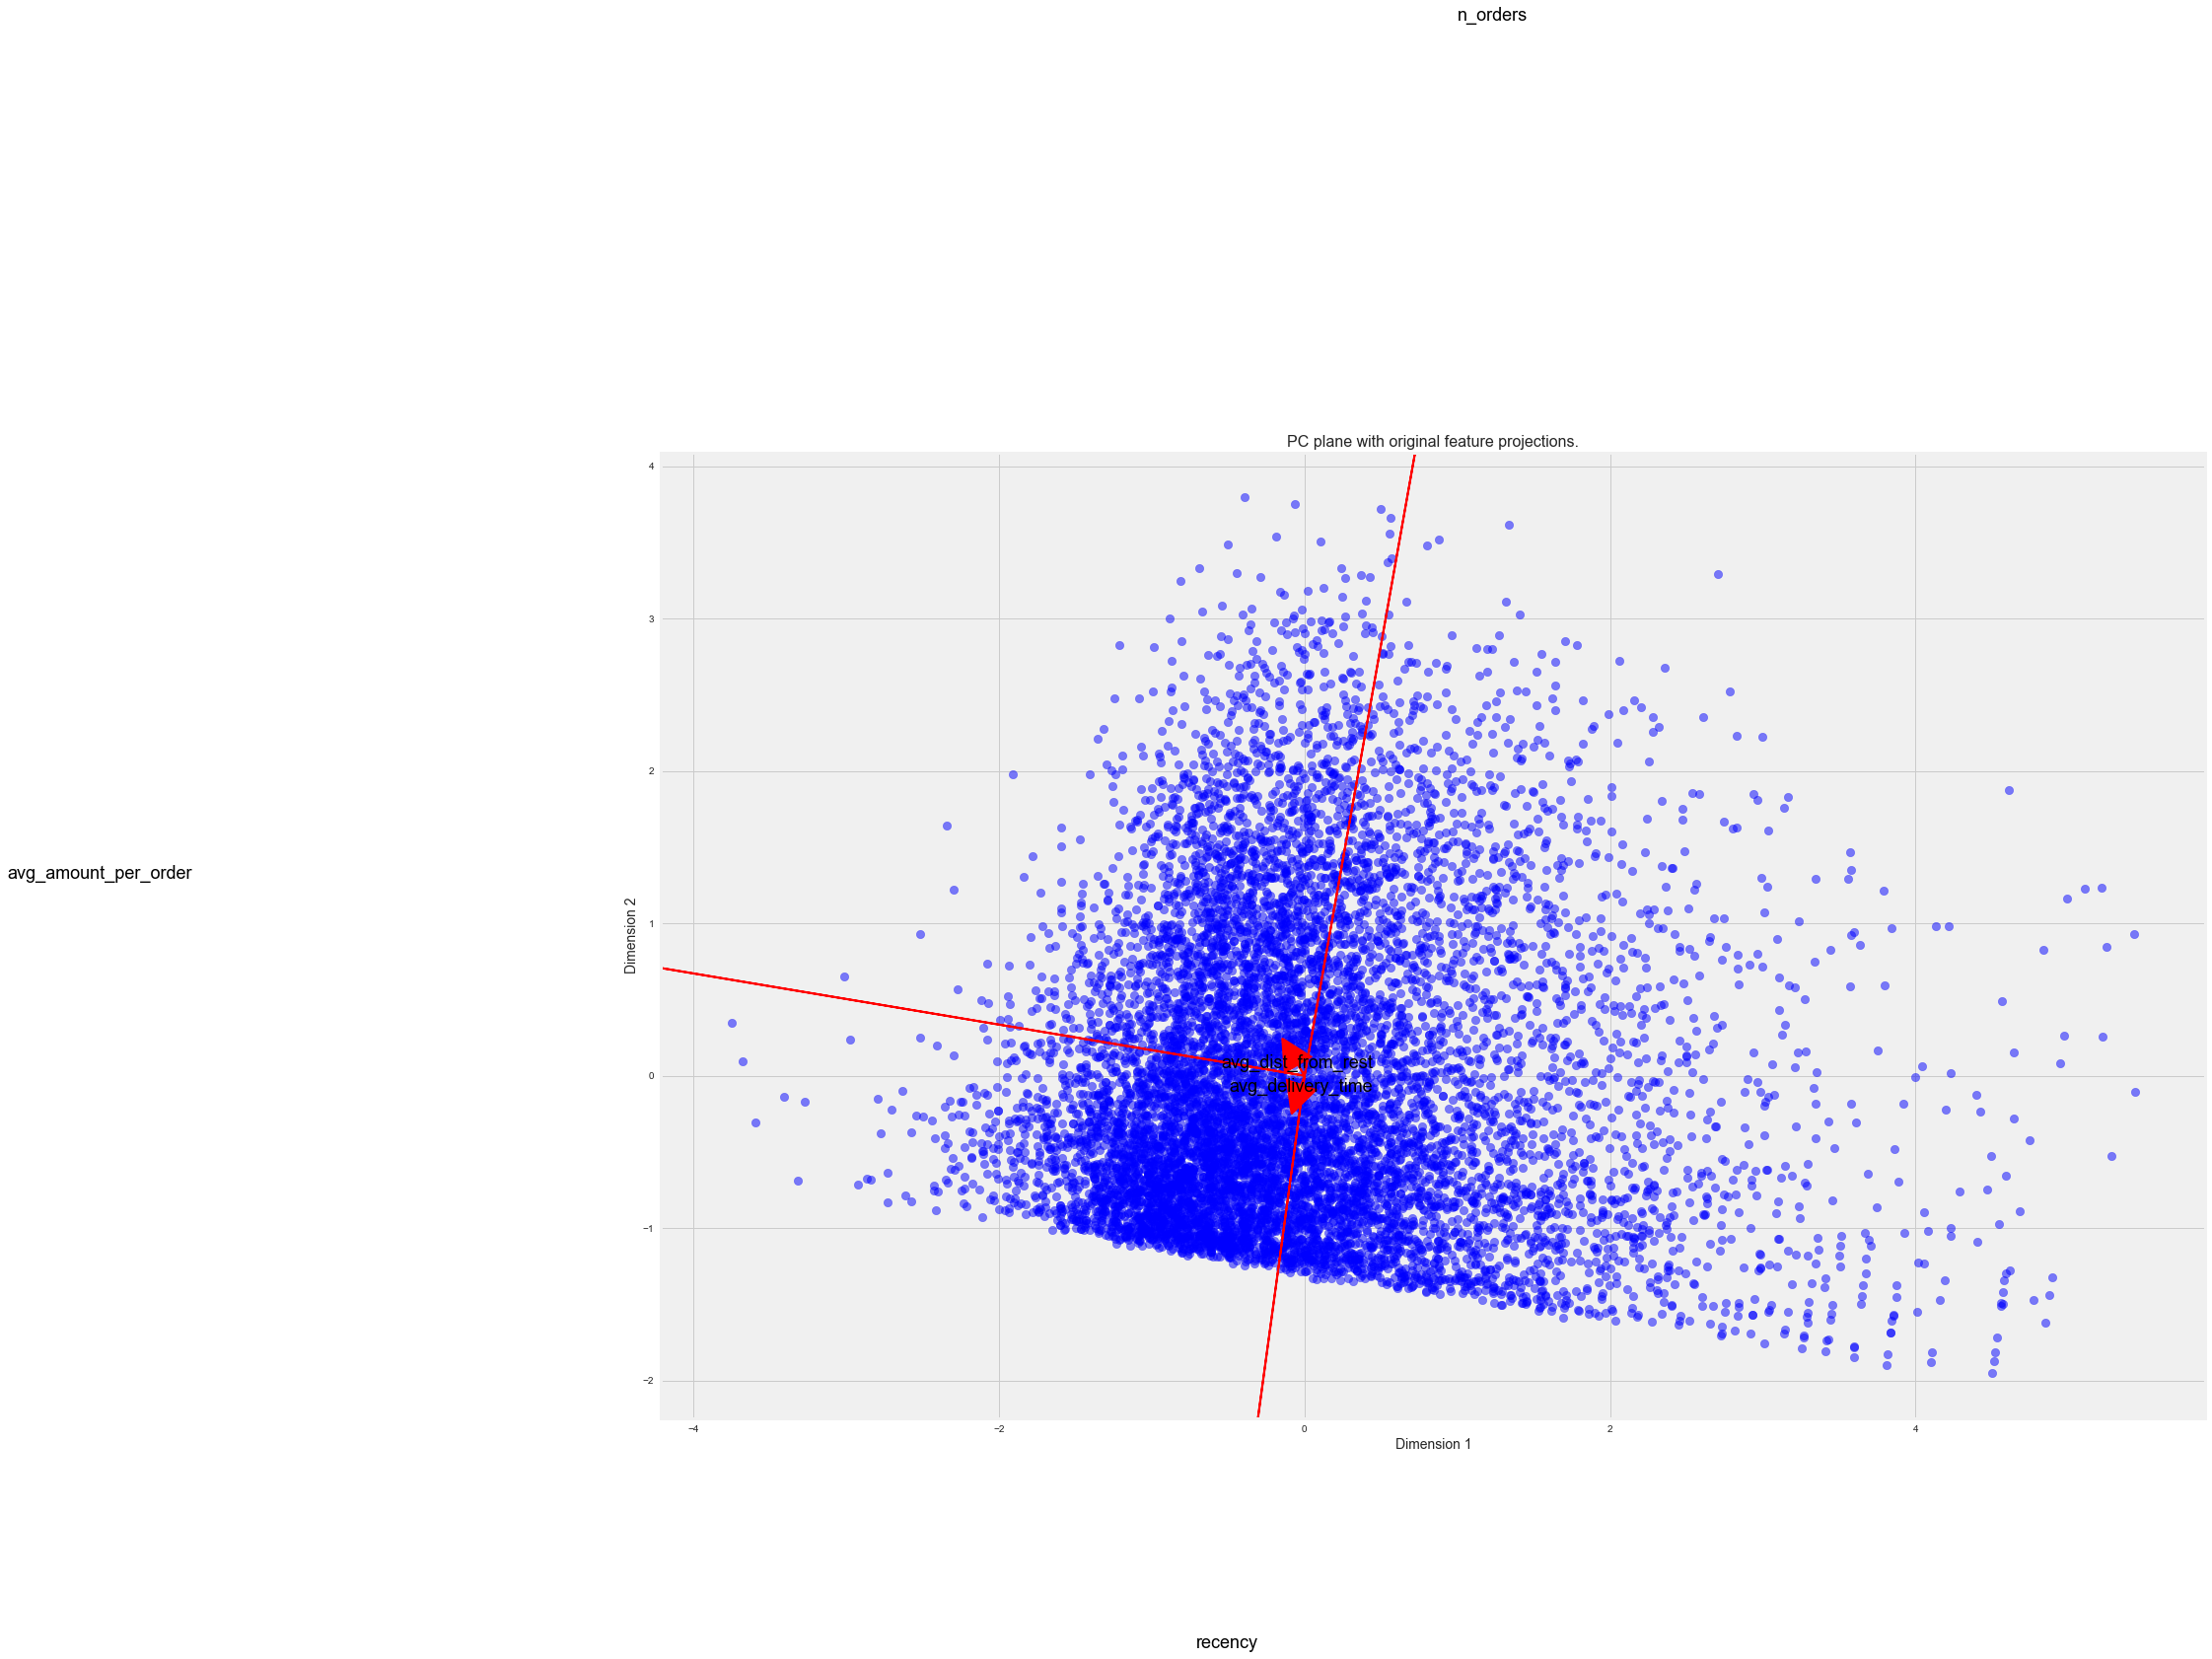

In [285]:
def biplot(final_data, reduced_data, pca):
    
    fig, ax = plt.subplots(figsize = (25,18))
    
    # scatterplot of the reduced data 
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # using scaling factors to make the arrows
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, final_data.columns[i], color='black', ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax

biplot(final_data, reduced_data, pca)

Let's check out how the sample data has changed after having a PCA transformation applied to it using only 2 dimensions.

# Clustering

Now, we will choose either K-means or GMM clustering algorithm to identify various customer segments in the data.
Let's start with GMM.

In [287]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [286]:
# Create range of clusters 
n_clusters = list(range(2,11))
print(n_clusters)

[2, 3, 4, 5, 6, 7, 8, 9, 10]


**Gaussian Mixture Implementation**

In [288]:
# loop through clusters
for n in n_clusters:
    # Apply GMM to the reduced data 
    clusterer = GaussianMixture(n_components=n).fit(reduced_data)

    # predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # find the cluster centers
    centers = clusterer.means_

    # predict the cluster for each transformed sample data point
    #sample_preds = clusterer.predict(pca_samples)

    # calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='mahalanobis')
    print "For n_clusters = {}. The average silhouette_score is : {}".format(n, score)

For n_clusters = 2. The average silhouette_score is : 0.358360614794
For n_clusters = 3. The average silhouette_score is : 0.388662112917
For n_clusters = 4. The average silhouette_score is : 0.280944967343
For n_clusters = 5. The average silhouette_score is : 0.289706881772
For n_clusters = 6. The average silhouette_score is : 0.294173809355
For n_clusters = 7. The average silhouette_score is : 0.327135861078
For n_clusters = 8. The average silhouette_score is : 0.234810260954
For n_clusters = 9. The average silhouette_score is : 0.3253960767
For n_clusters = 10. The average silhouette_score is : 0.279961991124


**KMeans Implementation**

In [272]:
# loop through clusters
for n in n_clusters:
    # apply KMeans to the reduced data 
    clusterer = KMeans(n_clusters=n).fit(reduced_data)

    # predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # find the cluster centers
    centers = clusterer.cluster_centers_

    # predict the cluster for each transformed sample data point
    #sample_preds = clusterer.predict(pca_samples)

    # calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='euclidean')
    print "For n_clusters = {}. The average silhouette_score is : {}".format(n, score)


For n_clusters = 2. The average silhouette_score is : 0.368197469593
For n_clusters = 3. The average silhouette_score is : 0.424686503793
For n_clusters = 4. The average silhouette_score is : 0.367007120773
For n_clusters = 5. The average silhouette_score is : 0.35795956109
For n_clusters = 6. The average silhouette_score is : 0.364554628181
For n_clusters = 7. The average silhouette_score is : 0.336528982666
For n_clusters = 8. The average silhouette_score is : 0.337292585449
For n_clusters = 9. The average silhouette_score is : 0.33099197669
For n_clusters = 10. The average silhouette_score is : 0.333265357908


Best score is obtained for 3 clusters by both methods.

# Cluster Visualization

In [302]:
# Extra code because we ran a loop on top and this resets to what we want
clusterer = GaussianMixture(n_components=3).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.means_

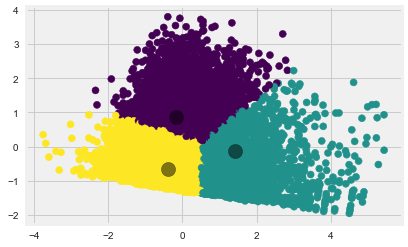

In [303]:
plt.scatter(reduced_data['Dimension 1'], reduced_data['Dimension 2'], c=kmeans.labels_, cmap='viridis')  
plt.scatter(centers[:,0], centers[:, 1], c='black', s=200, alpha=0.5);

# Data Recovery

In [306]:
# take inverse transform of the centers
log_centers = pca.inverse_transform(centers)

# take exponential of the centers
true_centers = np.exp(log_centers)

# display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = model_data.keys())
true_centers.index = segments
display(true_centers)

,n_orders,avg_dist_from_rest,avg_delivery_time,recency,avg_amount_per_order
Segment 0,10.0,3.0,35.0,44.0,320.0
Segment 1,2.0,3.0,36.0,92.0,301.0
Segment 2,5.0,3.0,35.0,63.0,57.0


Let's take a guess about the characteristics of the customers belonging to each segments

-  **Segment 0**: This segment belongs to the customers that order frequently (make atleast 1 order per month), have been most active on the app and spend a decent amount on the order. Reason could also be that they are closest to the restaurants.

-  **Segment 1**: This segment belongs to the customers that are not as frequent and do not use the app frequenctly (have not been active since past 3 months), but in the past have made orders with sufficient amount.

-  **Segment 2**: This segment belongs to the customers that neither very frequent or spend enough on orders. They have also lost touch with the app.

# Conclusions and Implications

So, how can this knowledge be used to improve the user experience or bring back customers on the app

So the company can run send push notification to customers belonging to segment 1 who were active big spenders before but have lost touch now. For the customers in segment 0, the customers can provide some offers/free delivery charges to make them more active on the app. For customers in segment 2, the company ca provide some discounts and combo offers which can motivate them to use the platform again.